Install neccesary packages and libraries. Allow Google access to files

In [351]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/NIH Test') # UPDATE PATH NAME AS NEEDED
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier

!pip install pandas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Combine metabolite data with meta data. I am currently only adding phenotype and volume of serum sample from the meta data.

In [352]:
metabolite_data = 'metabolite_data.xlsx' # UPDATE FILE NAME AS NEEDED
meta_data = 'metadata.xlsx' # UPDATE FILE NAME AS NEEDED

metabolite_data_excel = pd.read_excel(metabolite_data)
meta_data_excel = pd.read_excel(meta_data)

NUM_PATIENTS_META_DATA = meta_data_excel.shape[0] - 1
phenotype_dict = {} # create phenotype dictionary: phenotype_dict[patient_id] = phenotype of that patient
volume_dict = {}

for i in range(NUM_PATIENTS_META_DATA):
  phenotype_dict[meta_data_excel.iloc[i + 1][2]] = (meta_data_excel.iloc[i + 1][7]).lower() #index 2 is patient ID. Index 7 is phenotype
  volume_dict[meta_data_excel.iloc[i + 1][2]] = (meta_data_excel.iloc[i + 1][5]) #index 5 is volume

NUM_PATIENTS_METABOLITE_DATA = metabolite_data_excel.shape[0] - 5 #There are 5 junk rows
NUM_DATA_POINTS = metabolite_data_excel.shape[1] - 7 #There are 7 junk columns

full_data = {}
data_description = [] # data description is a list of the name of the value being measured. i.e. Carnitine
data_dict = {} # given patient id name as a key, the value is a dictionary of name and value of all data points
patient_ids = []
data_ids = []

for j in range(NUM_DATA_POINTS):
  data_description.append(metabolite_data_excel.iloc[0][j + 7])

for i in range(NUM_PATIENTS_METABOLITE_DATA):
  patient_id = metabolite_data_excel.iloc[i + 5][1]
  if isinstance(patient_id, (int, float)) and patient_id < 10000:
    int(patient_id)
    patient_ids.append(patient_id)
    data_dict[patient_id] = {}
    for j in range(NUM_DATA_POINTS):
      data_name = data_description[j]
      data_dict[patient_id][data_name] = metabolite_data_excel.iloc[i + 5][j + 7]
    phenotype = phenotype_dict[patient_id]
    data = data_dict[patient_id]
    volume = volume_dict[patient_id]
    full_data[patient_id] = (phenotype, data, volume)
  else:
    NUM_PATIENTS_METABOLITE_DATA -= 1

full_data["NUM_DATA_POINTS"] = NUM_DATA_POINTS
full_data["NUM_PATIENTS_METABOLITE_DATA"] = NUM_PATIENTS_METABOLITE_DATA


# full_data is a dictionary that stores the phenotype, metabolite data, and serum volume for each patient that has metabolite data.
# It also stores the number of data points measured and the number of patients that have metabolite data.
# If Patient 38 had a Marasmus phenotype and had measurement of .4 for Carnitine, and the vial contained 800 microliters off serumn, it would look like this:
# full_data[38] = ('Marasmus', {'Carnitine': .4}, 800)



Print out the unique phenotypes so user can decide which ones they want to keep.

In [353]:
unique_phenotypes = set(phenotype_dict.values())
print(unique_phenotypes)

{'kwashiorkor', 'moderate acute malnutrition', 'control', 'not recorded', 'marasmus kwashiorkor', 'marasmus'}


Theoretically, we might want to filter out certain phenotypes from the data. For instance, it seems "not recorded" might not be very helpful. If we do, set filer to True and put phenotypes you want to keep in keep. Case sensitivity doesn't matter. If you don't want to filter by phenotype, set filter equal to False.

In [354]:
filter = True
keep = ["Kwashiorkor", "Marasmus", "Marasmus Kwashiorkor", "control", "moderate acute malnutrition"]

In [355]:
if filter: #create new dictionary with only specified phenotypes
  for i in range(len(keep)):
    keep[i] = keep[i].lower()
  filtered_dict = {}
  filtered_patient_ids = []

  num_filtered_patients = 0
  num_patients = full_data["NUM_PATIENTS_METABOLITE_DATA"]
  for i in range(num_patients):
    patient_id = patient_ids[i]
    phenotype = full_data[patient_id][0]
    if phenotype in keep:
      filtered_dict[patient_id] = full_data[patient_id]
      num_filtered_patients += 1
      filtered_patient_ids.append(patient_id)
  filtered_dict["NUM_DATA_POINTS"] = full_data["NUM_DATA_POINTS"]
  filtered_dict["NUM_PATIENTS_METABOLITE_DATA"] = num_filtered_patients
  full_data = filtered_dict
  patient_ids = filtered_patient_ids


We now have a dictionary that stores the metabolite data and the meta data (currently just Phenotype) for the desired patients.

In [356]:
print(full_data)

{3: ('control', {'Carnitine': 23.90583617, 'Acetylcarnitine': 2.863448717, 'Propionylcarnitine': 0.401267126, 'Malonylcarnitine (Hydroxybutyrylcarnitine)': 0.08744123, 'Propenoylcarnitine': 0.002462, 'Butyrylcarnitine': 0.127978285, 'Butenylcarnitine': 0.000543719, 'Valerylcarnitine': 0.091131418, 'Tiglylcarnitine': 0, 'Decanoylcarnitine': 0.077586392, 'Tetradecenoylcarnitine': 0.017383058, 'Hexadecanoylcarnitine': 0.087100872, 'Octadecanoylcarnitine': 0.020183773, 'Octadecenoylcarnitine': 0.087866986, 'Octadecadienoylcarnitine': 0.062660434, 'Trigonelline': 0.6466399, 'Trimethylamine N-oxide': 2.338467223, 'Alanine ': 403.4270678, 'Arginine': 102.5975582, 'Asparagine ': 66.44953841, 'Aspartate': 42.35654535, 'Cysteine': 25.49734728, 'Glutamine ': 693.0288063, 'Glutamate': 67.5487755, 'Glycine': 369.2475847, 'Histidine': 89.30524437, 'Isoleucine': 39.38422106, 'Leucine': 120.8434083, 'Lysine': 60.81426903, 'Methionine': 19.04566936, 'Phenylalanine ': 59.1018657, 'Proline': 186.6613235,

EXPERIMENTAL: I looked ahead at the next couple of tasks I will work on in the coming weeks. I figured I would explore a little bit so I could familiarize myself with the concepts and start to learn what I know and don't know. The below code is to explore QC, PCA, Clustering and data visualizaiton.

In [357]:
num_data_points = full_data["NUM_DATA_POINTS"]
num_patients = full_data["NUM_PATIENTS_METABOLITE_DATA"]
data = [None] * num_patients
del full_data["NUM_DATA_POINTS"]
del full_data["NUM_PATIENTS_METABOLITE_DATA"]
list_of_patients = []

for i in range(num_patients):
    patient_id = patient_ids[i]
    list_of_data = full_data[patient_id][1]
    data_values = list(list_of_data.values())
    list_of_patients.append(data_values)
# replace outliers (3 (maybe will switch to 2) standard deviations from mean) and non-numeric/empty values with mean
array = pd.DataFrame(list_of_patients)
array = array.apply(pd.to_numeric, errors='coerce')

col_means = array.mean()
array_filled = array.fillna(col_means)
z_scores = np.abs(stats.zscore(array_filled))
array_no_outliers = array_filled.mask(z_scores > 3, col_means, axis=1) #maybe 2 standard deviations? i do not know what makes sense in this context
array = array_no_outliers




NUM_COMPONENTS = 10 # this is variable. I don't have a great way to determine this until after looking at graph.

pca = PCA(n_components=NUM_COMPONENTS)
principal_components = pca.fit_transform(array)

Now we want to add Phenotype to each entry

In [358]:
pca_and_phenotypes = [None] * num_patients
for i in range(num_patients):
  patient_id = patient_ids[i]
  pca_and_phenotypes[i] = (phenotype_dict[patient_id], principal_components[i])


Now we can plot which ever Principle Components (currently 1 and 2) as a scatterplot accross phenotypes to see if there is any visual correlation. It appears with the current data, there is not.

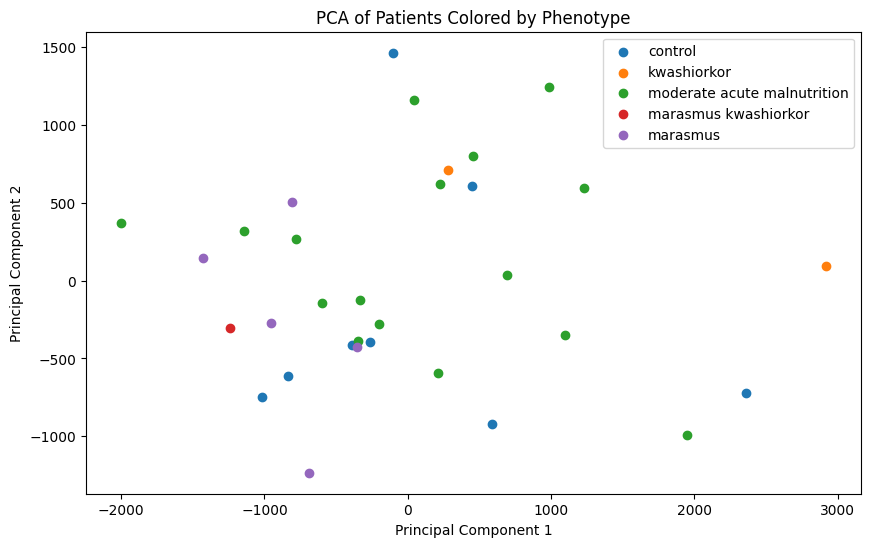

In [359]:
data = [{'Phenotype': item[0], 'PC1': item[1][0], 'PC2': item[1][1]} for item in pca_and_phenotypes]
principal_df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
for phenotype in principal_df['Phenotype'].unique():
    subset = principal_df[principal_df['Phenotype'] == phenotype]
    plt.scatter(subset['PC1'], subset['PC2'], label=phenotype)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('PCA of Patients Colored by Phenotype')
plt.show()

The below graphs describes what ratio of the explained variance each principle component represents. We see here that the first four principal components explain 94% of variance, which probably means that we can just focus on them. I am not sure what number is sufficient in the context of metabolomics.

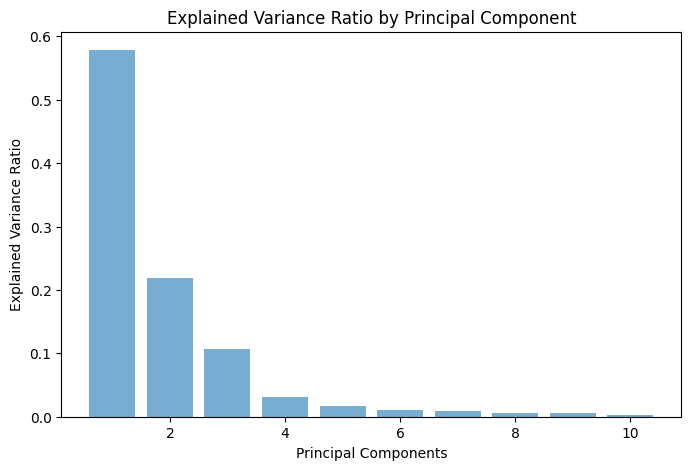

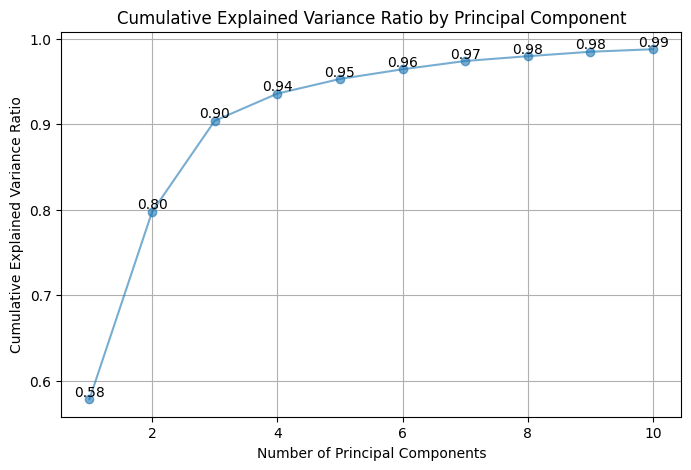

In [360]:
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-', alpha=0.6)
for i, value in enumerate(cumulative_explained_variance):
    plt.text(i + 1, value, f'{value:.2f}', ha='center', va='bottom')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Principal Component')
plt.grid(True)
plt.show()

In [361]:
pca_components = pca.components_

pca_components_df = pd.DataFrame(pca_components, columns=array.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])

top_n = 5
pc1_contributions = pca_components_df.loc['PC1'].abs().sort_values(ascending=False).head(top_n)
pc2_contributions = pca_components_df.loc['PC2'].abs().sort_values(ascending=False).head(top_n)
pc3_contributions = pca_components_df.loc['PC3'].abs().sort_values(ascending=False).head(top_n)
pc4_contributions = pca_components_df.loc['PC4'].abs().sort_values(ascending=False).head(top_n)


print(pc1_contributions.idxmax(), data_description[pc1_contributions.idxmax()])
print(pc2_contributions.idxmax(), data_description[pc2_contributions.idxmax()])
print(pc3_contributions.idxmax(), data_description[pc3_contributions.idxmax()])
print(pc4_contributions.idxmax(), data_description[pc4_contributions.idxmax()])




83 Lactic acid
657 Sum of hexose sugars
772 Triacylglyceride (18:1_34:1)
119 Cholesteryl ester 18:2


We now know the features that contribute the most to each of the top 4 principle components. Let us plot their values accross phenotype to see if we can see any trend.

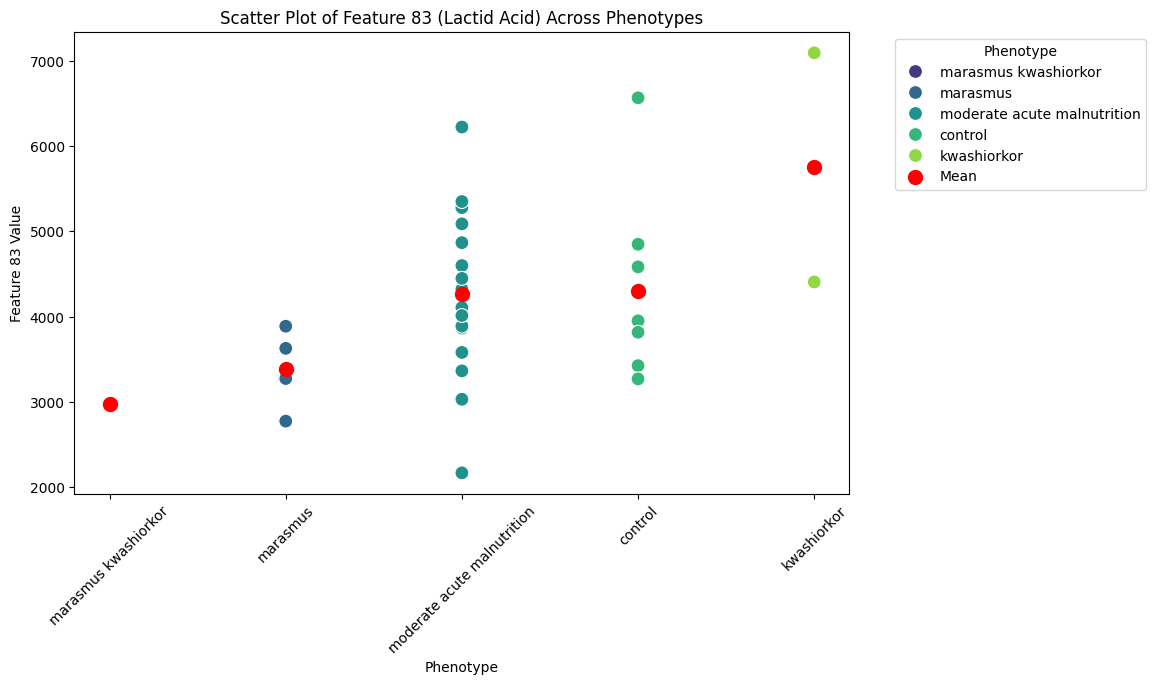

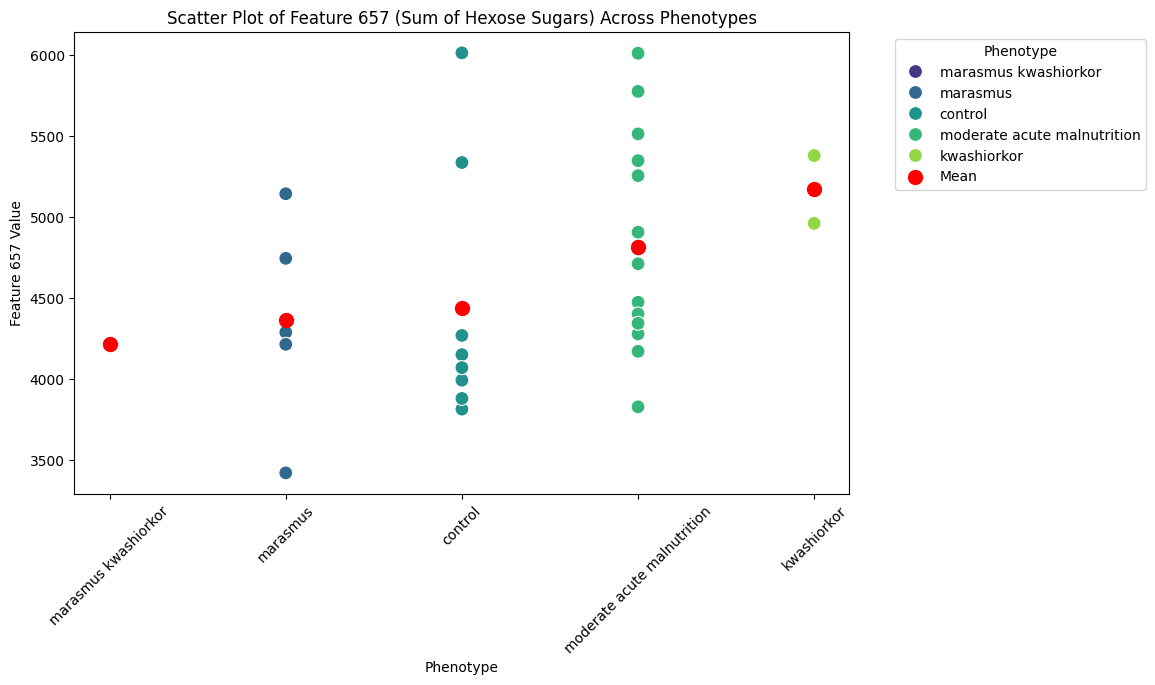

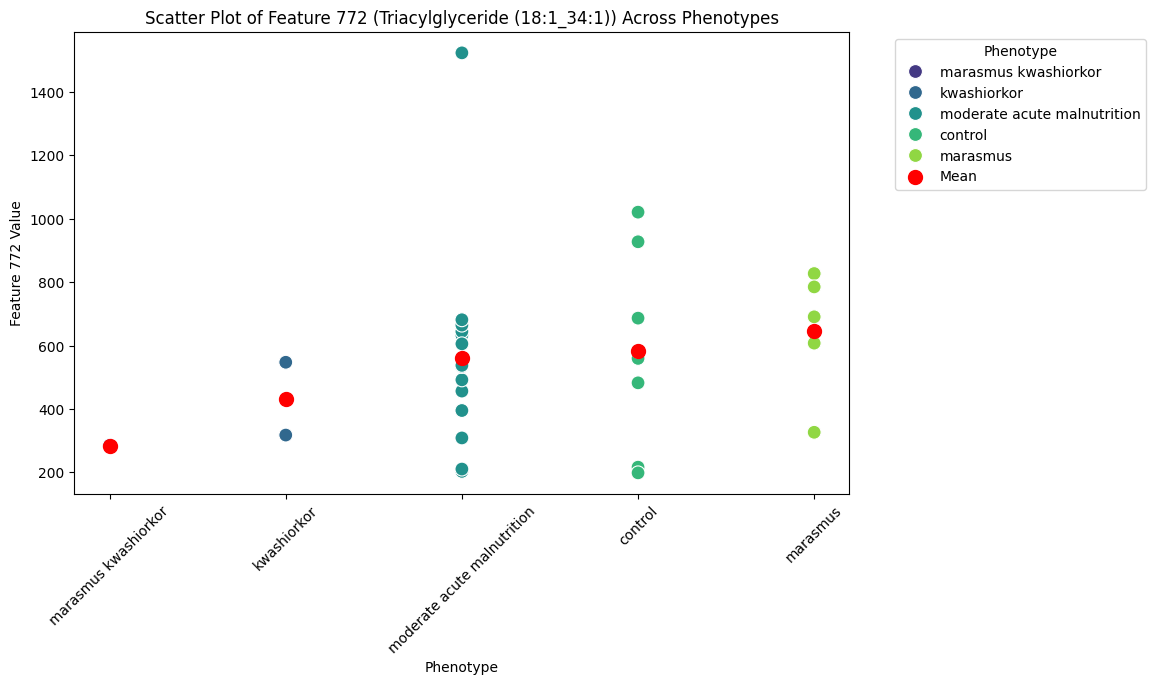

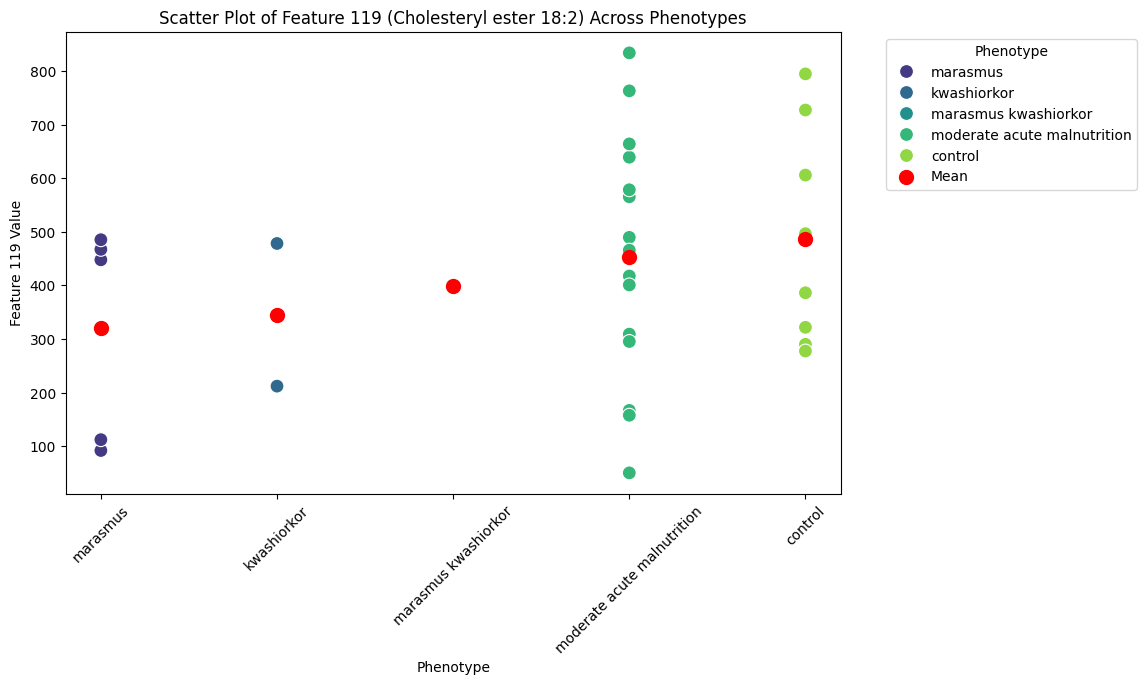

In [362]:
phenotypes = [phenotype_dict[patient_id] for patient_id in patient_ids]

feature_83_values = array[83]

feature_83_df = pd.DataFrame({'Feature_83': feature_83_values, 'Phenotype': phenotypes})
mean_values = feature_83_df.groupby('Phenotype')['Feature_83'].mean().reset_index()
sorted_phenotypes = mean_values.sort_values(by='Feature_83')['Phenotype']
feature_83_df['Phenotype'] = pd.Categorical(feature_83_df['Phenotype'], categories=sorted_phenotypes, ordered=True)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Phenotype', y='Feature_83', data=feature_83_df, hue='Phenotype', palette='viridis', s=100)
plt.scatter(x=mean_values['Phenotype'], y=mean_values['Feature_83'], color='red', s=100, label='Mean')

plt.title('Scatter Plot of Feature 83 (Lactid Acid) Across Phenotypes')
plt.xlabel('Phenotype')
plt.ylabel('Feature 83 Value')
plt.xticks(rotation=45)
plt.legend(title='Phenotype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

feature_657_values = array[657]

feature_657_df = pd.DataFrame({'Feature_657': feature_657_values, 'Phenotype': phenotypes})
mean_values = feature_657_df.groupby('Phenotype')['Feature_657'].mean().reset_index()
sorted_phenotypes = mean_values.sort_values(by='Feature_657')['Phenotype']
feature_657_df['Phenotype'] = pd.Categorical(feature_657_df['Phenotype'], categories=sorted_phenotypes, ordered=True)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Phenotype', y='Feature_657', data=feature_657_df, hue='Phenotype', palette='viridis', s=100)
plt.scatter(x=mean_values['Phenotype'], y=mean_values['Feature_657'], color='red', s=100, label='Mean')

plt.title('Scatter Plot of Feature 657 (Sum of Hexose Sugars) Across Phenotypes')
plt.xlabel('Phenotype')
plt.ylabel('Feature 657 Value')
plt.xticks(rotation=45)
plt.legend(title='Phenotype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

feature_772_values = array[772]

feature_772_df = pd.DataFrame({'Feature_772': feature_772_values, 'Phenotype': phenotypes})
mean_values = feature_772_df.groupby('Phenotype')['Feature_772'].mean().reset_index()
sorted_phenotypes = mean_values.sort_values(by='Feature_772')['Phenotype']
feature_772_df['Phenotype'] = pd.Categorical(feature_772_df['Phenotype'], categories=sorted_phenotypes, ordered=True)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Phenotype', y='Feature_772', data=feature_772_df, hue='Phenotype', palette='viridis', s=100)
plt.scatter(x=mean_values['Phenotype'], y=mean_values['Feature_772'], color='red', s=100, label='Mean')

plt.title('Scatter Plot of Feature 772 (Triacylglyceride (18:1_34:1)) Across Phenotypes')
plt.xlabel('Phenotype')
plt.ylabel('Feature 772 Value')
plt.xticks(rotation=45)
plt.legend(title='Phenotype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

feature_119_values = array[119]

feature_119_df = pd.DataFrame({'Feature_119': feature_119_values, 'Phenotype': phenotypes})
mean_values = feature_119_df.groupby('Phenotype')['Feature_119'].mean().reset_index()
sorted_phenotypes = mean_values.sort_values(by='Feature_119')['Phenotype']
feature_119_df['Phenotype'] = pd.Categorical(feature_119_df['Phenotype'], categories=sorted_phenotypes, ordered=True)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Phenotype', y='Feature_119', data=feature_119_df, hue='Phenotype', palette='viridis', s=100)
plt.scatter(x=mean_values['Phenotype'], y=mean_values['Feature_119'], color='red', s=100, label='Mean')

plt.title('Scatter Plot of Feature 119 (Cholesteryl ester 18:2) Across Phenotypes')
plt.xlabel('Phenotype')
plt.ylabel('Feature 119 Value')
plt.xticks(rotation=45)
plt.legend(title='Phenotype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Here are the graphs of the 4 components. There seems to be potentially a correlation, but more data would definitely be helpful.

Now, let us experiment with Cluster Analysis. This is the elbow method and aims to help predict the best number of clusters.

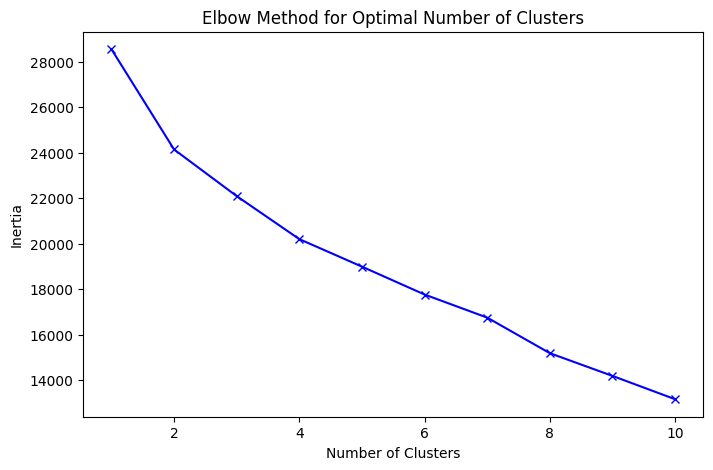

In [363]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(array)

inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()



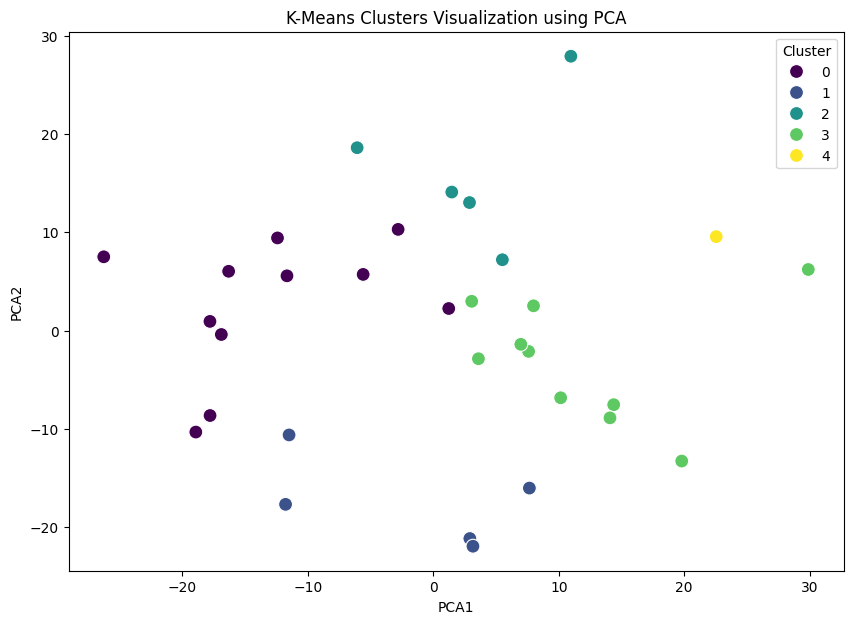

In [364]:
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init = 10)
cluster_labels = kmeans.fit_predict(scaled_data)

array = pd.concat([array_no_outliers, pd.DataFrame({'Cluster': cluster_labels}, index=array_no_outliers.index)], axis=1)

pca = PCA(n_components=2)
data_pca = pca.fit_transform(scaled_data)


df_pca = pd.DataFrame(data_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = cluster_labels

plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_pca, palette='viridis', s=100)
plt.title('K-Means Clusters Visualization using PCA')
plt.show()

It doesn't look very good right now. But in theory with more robust data, it will look better. Next, I will experiment with Agglomerative Clustering. I added a decision boundary mesh background.

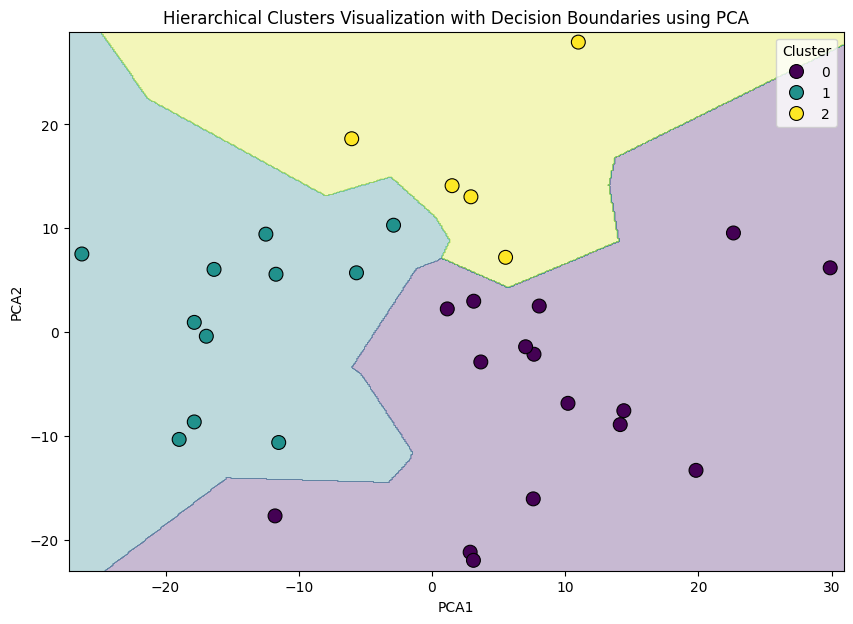

In [365]:
array.columns = array.columns.astype(str)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(array)

hierarchical = AgglomerativeClustering(n_clusters=3) # 3 seems to make the most sense
cluster_labels = hierarchical.fit_predict(scaled_data)
array['Cluster'] = cluster_labels

pca = PCA(n_components=2)
data_pca = pca.fit_transform(scaled_data)
df_pca = pd.DataFrame(data_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = cluster_labels

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(df_pca[['PCA1', 'PCA2']], df_pca['Cluster'])

x_min, x_max = df_pca['PCA1'].min() - 1, df_pca['PCA1'].max() + 1
y_min, y_max = df_pca['PCA2'].min() - 1, df_pca['PCA2'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_df = pd.DataFrame(grid_points, columns=['PCA1', 'PCA2'])
Z = knn.predict(grid_points_df)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')

sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_pca, palette='viridis', s=100, edgecolor='k')

plt.title('Hierarchical Clusters Visualization with Decision Boundaries using PCA')
plt.show()

This looks a little bit more "cluster" like, but I am not really familiar with the algorithm behind Agglomerative Clustering so I should read up on that. I added a decision boundary mesh background.  It seems like PCA1 and PCA2 don't really have much of a correlation with phenotype overall. I am wondering what that means and if I can "rearrange" the data so that PCA1/2 seem to have more effect on phenotype.

TODO:

Streamline program so that we calculate the best number of Principal Components. Then calculate score for each of the features based off of the Principal Components. Then plot the highest scoring features.

Perform more exhaustive Data Cleanup/Validation